# Test curve fitting

The function `y = sinc(10 * x)` is fitted using a Shallow Neural Network with 61 parameters.
Despite the triviality of the problem, first-order methods such as Adam fail to converge, while Levenberg–Marquardt converges rapidly with very low loss values. The values of learning_rate were chosen experimentally on the basis of the results obtained by each algorithm.

In [22]:
import os

os.chdir("../content")

lm_dir = "tf-levenberg-marquardt"
if not os.path.exists(lm_dir):
  !git clone https://github.com/fabiodimarco/$lm_dir

os.chdir(lm_dir)

FileNotFoundError: [Errno 2] No such file or directory: '../content'

In [ ]:
!pip install tensorflow 

# Setup Levenberg-Marquardt
### Install dependencies from GitHub

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import zscore
from sklearn.preprocessing import MaxAbsScaler

def peaks(grid):
    x = np.linspace(-2, 2, grid)
    y = np.linspace(-2, 2, grid)
    x, y = np.meshgrid(x, y)
    z = 3*(1-x)**2 * np.exp(-(x**2) - (y+1)**2) - 10*(x/5 - x**3 - y**5) * np.exp(-x**2 - y**2) - 1/3 * np.exp(-(x+1)**2 - y**2)
    return x, y, z

def create_dataframe(grid):
   x, y, z = peaks(grid)
   data = {'X': x.flatten(), 'Y': y.flatten(), 'Z': z.flatten()}
   df = pd.DataFrame(data)
   return df

In [ ]:
df_25 = create_dataframe(grid=5)
df_1000 = create_dataframe(grid=32)

In [ ]:
df_25

X    Y         Z
0  -2.0 -2.0  0.046835
1  -1.0 -2.0 -0.592128
2   0.0 -2.0 -4.759612
3   1.0 -2.0 -2.102351
4   2.0 -2.0 -0.061640
5  -2.0 -1.0 -0.130053
6  -1.0 -1.0  1.855892
7   0.0 -1.0 -0.723906
8   1.0 -1.0 -0.272917
9   2.0 -1.0  0.499636
10 -2.0  0.0 -1.332690
11 -1.0  0.0 -1.652345
12  0.0  0.0  0.981012
13  1.0  0.0  2.936930
14  2.0  0.0  1.412161
15 -2.0  1.0 -0.480759
16 -1.0  1.0  0.228899
17  0.0  1.0  3.688630
18  1.0  1.0  2.433789
19  2.0  1.0  0.580455
20 -2.0  2.0  0.079668
21 -1.0  2.0  2.096679
22  0.0  2.0  5.859129
23  1.0  2.0  2.209935
24  2.0  2.0  0.132849

In [ ]:
df_1000

X    Y         Z
0    -2.000000 -2.0  0.046835
1    -1.870968 -2.0  0.060663
2    -1.741935 -2.0  0.070183
3    -1.612903 -2.0  0.067332
4    -1.483871 -2.0  0.039844
...        ...  ...       ...
1019  1.483871  2.0  0.708371
1020  1.612903  2.0  0.487302
1021  1.741935  2.0  0.325461
1022  1.870968  2.0  0.211038
1023  2.000000  2.0  0.132849

[1024 rows x 3 columns]

In [ ]:
def split_df(df):
    df = df.sample(frac=1).reset_index(drop=True)  # Randomiza as linhas

    _input = np.vstack([df['X'], df['Y']]).T
    _output = np.array(df['Z'])
    return (_input, _output)

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import levenberg_marquardt as lm
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_squared_error
from keras import regularizers
from keras import initializers

class TrainWithSmallDataset:
    def __init__(self, batch_size=1000):
      self.batch_size = batch_size

    def create_dataset(self, input, output):
      input = tf.expand_dims(tf.cast(input, tf.float32), axis=-1)
      output = tf.expand_dims(tf.cast(output, tf.float32), axis=-1)

      train_dataset = tf.data.Dataset.from_tensor_slices((input, output))
      train_dataset = train_dataset.shuffle(len(input))
      train_dataset = train_dataset.batch(self.batch_size).cache()
      train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)
      return (train_dataset, input, output)


    def split_dataset(self, input, output, sup_input, sup_output):

      input_train, input_vt, output_train, output_vt = train_test_split(input, output, test_size=0.3, random_state=42)
      input_val, input_test, output_val, output_test = train_test_split(input_vt, output_vt, test_size=0.5, random_state=42)

      self.train_dataset, self.train_input, self.train_output = self.create_dataset(input_train, output_train)
      self.val_dataset, self.val_input, self.val_output = self.create_dataset(input_val, output_val)
      self.test_dataset, self.test_input, self.test_output = self.create_dataset(input_test, output_test)
      self.vt_dataset, self.vt_input, self.vt_output = self.create_dataset(input_vt, output_vt)
      self.sup_dataset, self.sup_input, self.sup_output = self.create_dataset(sup_input, sup_output)
      self.dataset, self.input, self.output = self.create_dataset(input, output)


    def create_model(self, input_size=2, sumary=False):
      regularizer = regularizers.L2(0.2)
      initializer = initializers.RandomUniform(minval=-0.5, maxval=0.5, seed=42)

      self.model = tf.keras.Sequential([
          tf.keras.layers.Dense(30,
                                activation='tanh',
                                input_shape=(input_size,),
                                kernel_regularizer=regularizer,
                                kernel_initializer=initializer,
                                ),
          tf.keras.layers.Dense(16,
                                activation='tanh',
                                kernel_regularizer=regularizer,
                                kernel_initializer=initializer,
                                ),
          tf.keras.layers.Dense(1,
                                activation='linear',
                                kernel_regularizer=regularizer,
                                kernel_initializer=initializer,
)])

      if (sumary == True):
        self.model.summary()

      self.model.compile(
          optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
          loss=tf.keras.losses.MeanSquaredError())

      self.lm_model = lm.ModelWrapper(
          tf.keras.models.clone_model(self.model))

      self.lm_model.compile(
          optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
          loss=lm.MeanSquaredError())

    def train_using_lm(self, train_dataset, epochs=1000):
      early_stopping_monitor = EarlyStopping(monitor='val_loss',
                                              patience=6,
                                              restore_best_weights=True)

      t2_start = time.perf_counter()
      self.results = self.lm_model.fit(train_dataset,
                                            epochs=epochs,
                                            validation_data=self.val_dataset,
                                            callbacks=[early_stopping_monitor],
                                            verbose=0)
      t2_stop = time.perf_counter()
      print("Elapsed time: ", t2_stop - t2_start)
      print ("Stopped at epoch: ", early_stopping_monitor.stopped_epoch)

    def get_metrics(self):
      pred = self.lm_model.predict(self.input).flatten()
      test_pred = self.lm_model.predict(self.test_input).flatten()
      val_pred = self.lm_model.predict(self.val_input).flatten()
      vt_pred = self.lm_model.predict(self.vt_input).flatten()
      sup_pred = self.lm_model.predict(self.sup_input).flatten()

      r2 = r2_score(self.output, pred)
      r2_test = r2_score(self.test_output, test_pred)
      r2_val = r2_score(self.val_output, val_pred)
      r2_vt = r2_score(self.vt_output, vt_pred)
      r2_sup = r2_score(self.sup_output, sup_pred)

      mse = mean_squared_error(self.output, pred)
      mse_test = mean_squared_error(self.test_output, test_pred)
      mse_val = mean_squared_error(self.val_output, val_pred)
      mse_vt = mean_squared_error(self.vt_output, vt_pred)
      mse_sup = mean_squared_error(self.sup_output, sup_pred)

      metrics = {
                      'r2': r2,
                      'r2_sup': r2_sup,
                      'r2_test': r2_test,
                      'r2_val': r2_val,
                      'r2_vt': r2_vt,
                      'mse': mse,
                      'mse_sup': mse_sup,
                      'mse_test': mse_test,
                      'mse_val': mse_val,
                      'mse_vt': mse_vt
                      }

      return metrics



In [23]:
from keras import saving
from keras import models

class Tester:
  def __init__(self, run_times=500):
    self.run_times = run_times
    self.better_results = {}
    self.better_metrics = []

  def PrepareTraining(self):
    trainer = TrainWithSmallDataset()
    input_25, output_25 = split_df(df_25)
    input_1000, output_1000 = split_df(df_1000)
    trainer.split_dataset(input_25, output_25, input_1000, output_1000)
    return (trainer)

  def Train(self, trainer, epochs=500):
    trainer.create_model()
    trainer.train_using_lm(trainer.train_dataset, epochs=epochs)
    return(trainer.get_metrics(), trainer.model, trainer.results)

  def Loop(self, sort_by, boundarie):
    betters = 0
    
    for i in range(self.run_times):
      print (f"++++++++++++++++++++++++++ {i + 1} ++++++++++++++++++++++++++")
      trainer = self.PrepareTraining()
      metrics, model, history = self.Train(trainer)
      if (metrics[sort_by] <= boundarie): # should be >= to acsending metrics
        fileName = f"/model_{betters}.keras"
        path = f"../../Teste01/models/" + fileName
        open(path,'w').close()

        self.better_metrics.append(metrics)
        self.better_results[path] = (metrics, history, model)
        saving.save_model(model, path)
        betters += 1

  def PlotBetterResults(self):
    trainer = self.PrepareTraining()
    self.better_metrics.sort(key=lambda x: x['mse_sup'])
    df = pd.DataFrame(self.better_metrics)
    display(df)
    
    for file_path, data in self.better_results.items():
        metric, history, model = data[0], data[1], data[2]
        print(metric)
        self.PlotResults(model,
                          trainer.sup_input,
                          trainer.test_input,
                          trainer.sup_output,
                          trainer.test_output,
                          history)

  def PlotResults(self, model, sup_input, test_input, sup_output, test_output, results):
      sup_prediction = model.predict(sup_input)
      test_prediction = model.predict(test_input)

      fig = plt.figure(figsize=(18, 6))
      ax0 = fig.add_subplot(1, 3, 1, projection='3d')
      ax2 = fig.add_subplot(1, 3, 2, projection='3d')
      ax1 = fig.add_subplot(1, 3, 3)

      ax0.set_title('Superficie Fit')
      ax0.scatter(sup_input[:, 0], sup_input[:, 1], sup_prediction, c='r', marker='s', label="lm")
      ax0.scatter(sup_input[:, 0], sup_input[:, 1], sup_output, c='b', marker='o', label="reference")
      ax0.legend()

      ax2.set_title('Teste Fit')
      ax2.scatter(test_input[:, 0], test_input[:, 1], test_prediction, c='r', marker='s', label="lm")
      ax2.scatter(test_input[:, 0], test_input[:, 1], test_output, c='b', marker='o', label="reference")
      ax2.legend()

      ax1.plot(results.history['loss'], label='Erro Treino')
      ax1.plot(results.history['val_loss'], label='Erro validação')
      ax1.set_title('Histórico de Treinamento')
      ax1.set_ylabel('Função de Custo')
      ax1.set_xlabel('Épocas de Treinamento')
      ax1.legend(['Erro Treino', 'Erro validação'])

      plt.show()

# Treinando com 25 dados

In [24]:
tester = Tester(run_times=250)

In [25]:
tester.Loop(sort_by='mse_sup', boundarie=2.5)

++++++++++++++++++++++++++ 1 ++++++++++++++++++++++++++
Elapsed time:  2.382212255999548
Stopped at epoch:  69
32/32 [==============================] - 0s 3ms/step
++++++++++++++++++++++++++ 2 ++++++++++++++++++++++++++
Elapsed time:  2.6878725760016096
Stopped at epoch:  96
32/32 [==============================] - 0s 2ms/step
++++++++++++++++++++++++++ 3 ++++++++++++++++++++++++++
Elapsed time:  13.136363079000148
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
++++++++++++++++++++++++++ 4 ++++++++++++++++++++++++++
Elapsed time:  0.46169205799924384
Stopped at epoch:  8
32/32 [==============================] - 0s 2ms/step
++++++++++++++++++++++++++ 5 ++++++++++++++++++++++++++
Elapsed time:  2.126836598999944
Stopped at epoch:  70
32/32 [==============================] - 0s 2ms/step
++++++++++++++++++++++++++ 6 ++++++++++++++++++++++++++
Elapsed time:  0.4723275840005954
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse   mse_sup  \
0   0.852402  0.693015  0.310946  0.797743  0.759526  0.619439  2.052807   
1   0.865735  0.670503  0.425485  0.756155  0.686916  0.563480  2.203345   
2   0.849202  0.665339 -0.263071  0.815968  0.657404  0.632866  2.237877   
3   0.818009  0.657933  0.087282  0.766199  0.675289  0.763779  2.287406   
4   0.891155  0.656779  0.545542  0.720448  0.703443  0.456798  2.295117   
5   0.817801  0.653675 -6.319348  0.638081  0.587450  0.764650  2.315875   
6   0.879265  0.647247 -0.169301  0.777202  0.666432  0.506698  2.358860   
7   0.841148  0.647042  0.340794  0.807716  0.756813  0.666669  2.360233   
8   0.847495  0.641139 -0.380325  0.811520  0.669921  0.640029  2.399705   
9   0.888510  0.640442  0.356139  0.808770  0.727872  0.467899  2.404369   
10  0.888407  0.638560  0.662150  0.746784  0.724755  0.468331  2.416953   
11  0.836145  0.633577  0.257539  0.563435  0.658008  0.687664  2.450270   
12  0.866020  0.630437  0.582968  0.858556  0.840527  0.562284  2.471267   

    mse_test   mse_val    mse_vt  
0   0.887418  2.983386  1.935402  
1   1.537446  1.816276  1.676861  
2   2.967853  0.949935  1.958894  
3   1.508235  2.368519  1.938377  
4   0.406772  2.095775  1.251274  
5   1.040053  3.010995  2.025524  
6   1.802455  0.974566  1.388510  
7   1.413795  2.752259  2.083027  
8   1.939550  1.864473  1.902012  
9   1.315782  1.232612  1.274197  
10  1.178147  1.570828  1.374488  
11  1.479304  2.173947  1.826626  
12  0.446598  1.288835  0.867716

{'r2': 0.8660203787868903, 'r2_sup': 0.6304373760213886, 'r2_test': 0.5829684604510477, 'r2_val': 0.8585560793908356, 'r2_vt': 0.840526768119924, 'mse': 0.56228375, 'mse_sup': 2.471267, 'mse_test': 0.44659775, 'mse_val': 1.2888347, 'mse_vt': 0.86771613}
32/32 [==============================] - 0s 725us/step


1/1 [==============================] - 0s 33ms/step


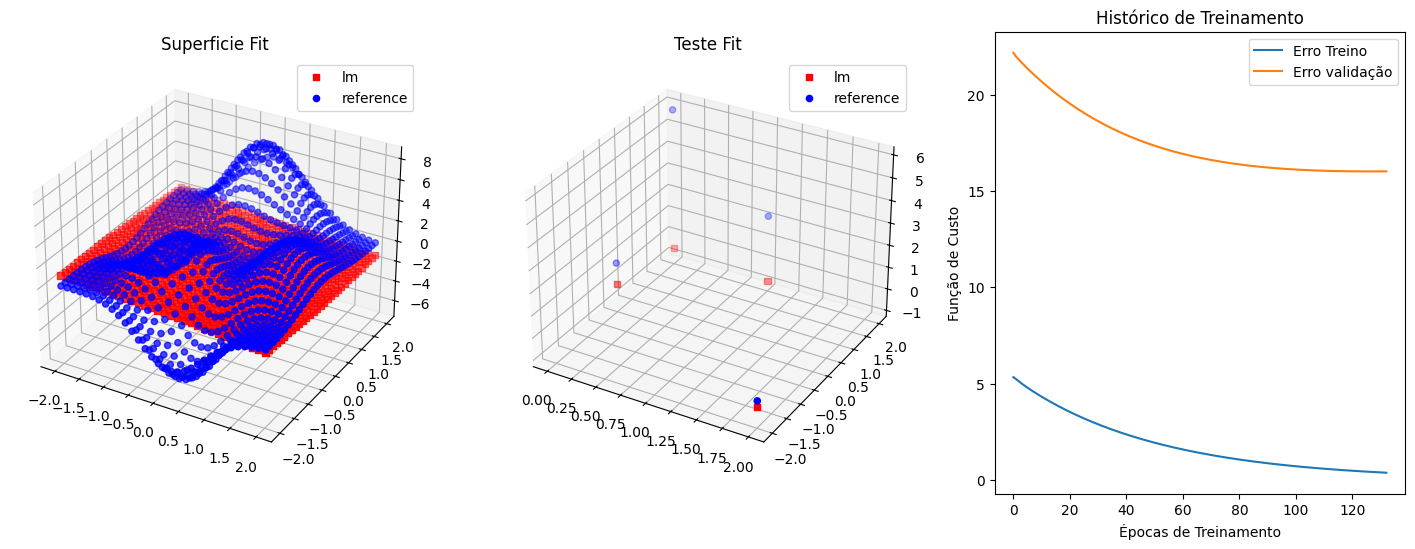

{'r2': 0.8411477620630823, 'r2_sup': 0.6470417538771334, 'r2_test': 0.3407939542248033, 'r2_val': 0.8077161832581292, 'r2_vt': 0.7568131274123853, 'mse': 0.66666883, 'mse_sup': 2.3602333, 'mse_test': 1.413795, 'mse_val': 2.7522588, 'mse_vt': 2.083027}
1/1 [==============================] - 0s 15ms/step


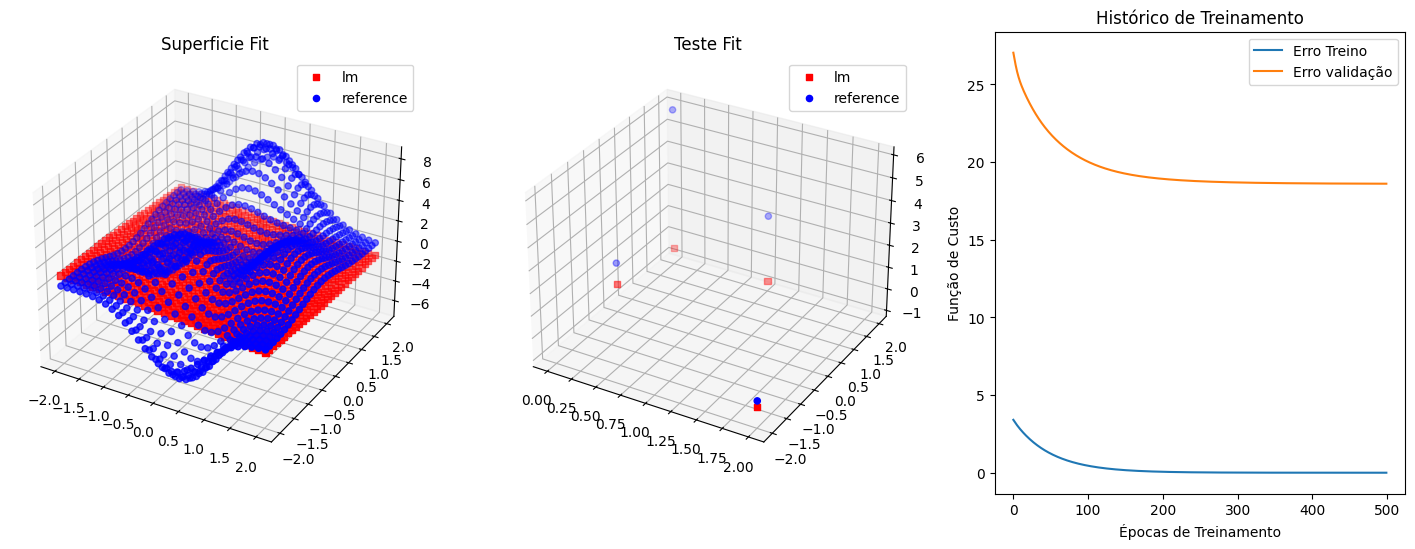

{'r2': 0.8911552742015649, 'r2_sup': 0.6567794995161934, 'r2_test': 0.5455423427919779, 'r2_val': 0.7204480105774984, 'r2_vt': 0.7034432936528714, 'mse': 0.45679802, 'mse_sup': 2.2951171, 'mse_test': 0.40677243, 'mse_val': 2.0957747, 'mse_vt': 1.2512736}
1/1 [==============================] - 0s 15ms/step


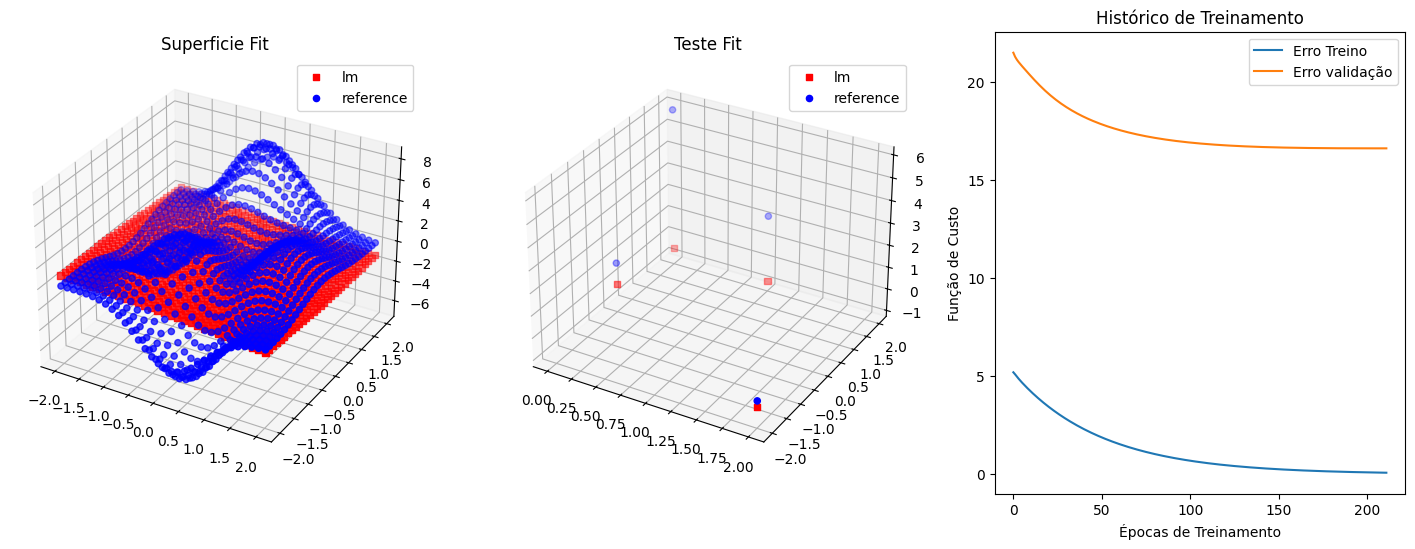

{'r2': 0.8885101471056838, 'r2_sup': 0.6404415653410792, 'r2_test': 0.3561389141931959, 'r2_val': 0.8087704814321228, 'r2_vt': 0.7278720993792327, 'mse': 0.46789905, 'mse_sup': 2.4043689, 'mse_test': 1.3157823, 'mse_val': 1.2326124, 'mse_vt': 1.2741973}
1/1 [==============================] - 0s 15ms/step


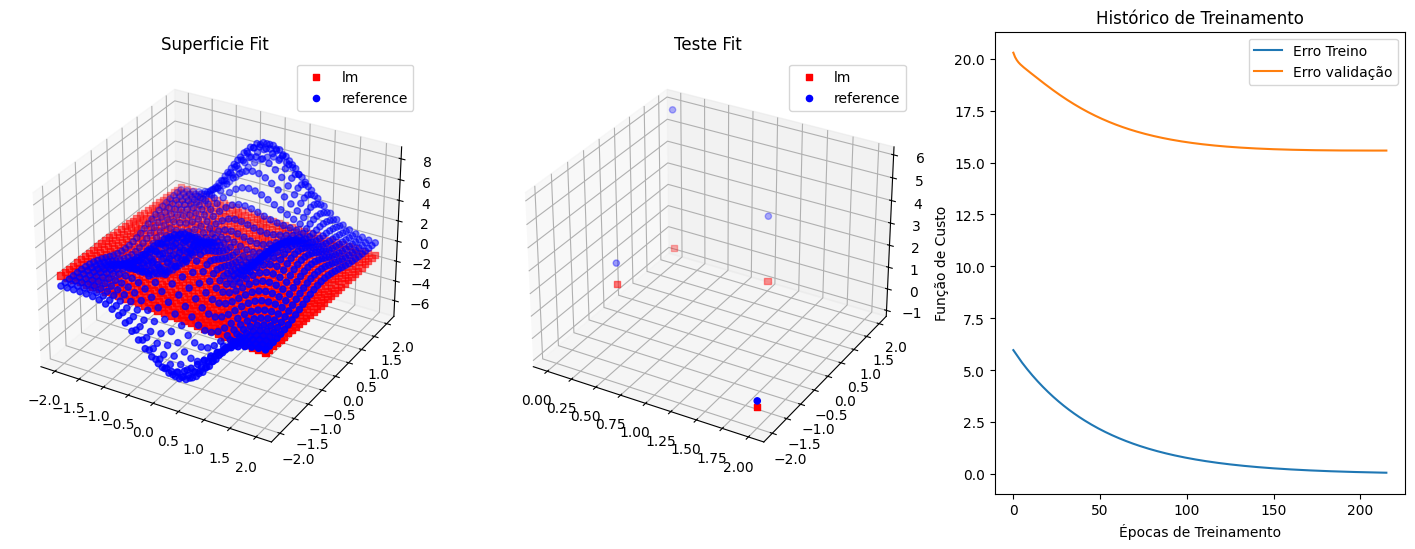

{'r2': 0.8792651430099944, 'r2_sup': 0.6472471955144161, 'r2_test': -0.16930062720780814, 'r2_val': 0.777201528650305, 'r2_vt': 0.6664324130183601, 'mse': 0.50669837, 'mse_sup': 2.3588598, 'mse_test': 1.802455, 'mse_val': 0.97456634, 'mse_vt': 1.3885105}
1/1 [==============================] - 0s 45ms/step


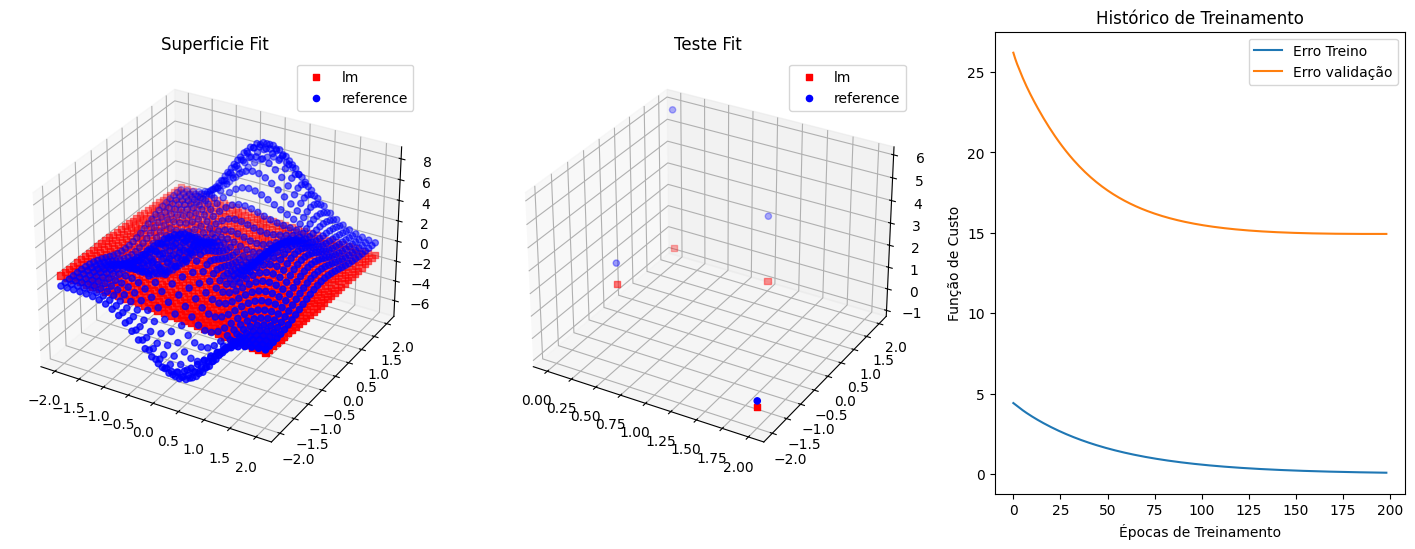

{'r2': 0.8657352803460789, 'r2_sup': 0.6705034494750337, 'r2_test': 0.42548492881793976, 'r2_val': 0.7561551360454437, 'r2_vt': 0.6869156440249777, 'mse': 0.5634803, 'mse_sup': 2.2033448, 'mse_test': 1.5374457, 'mse_val': 1.8162757, 'mse_vt': 1.6768607}
1/1 [==============================] - 0s 39ms/step


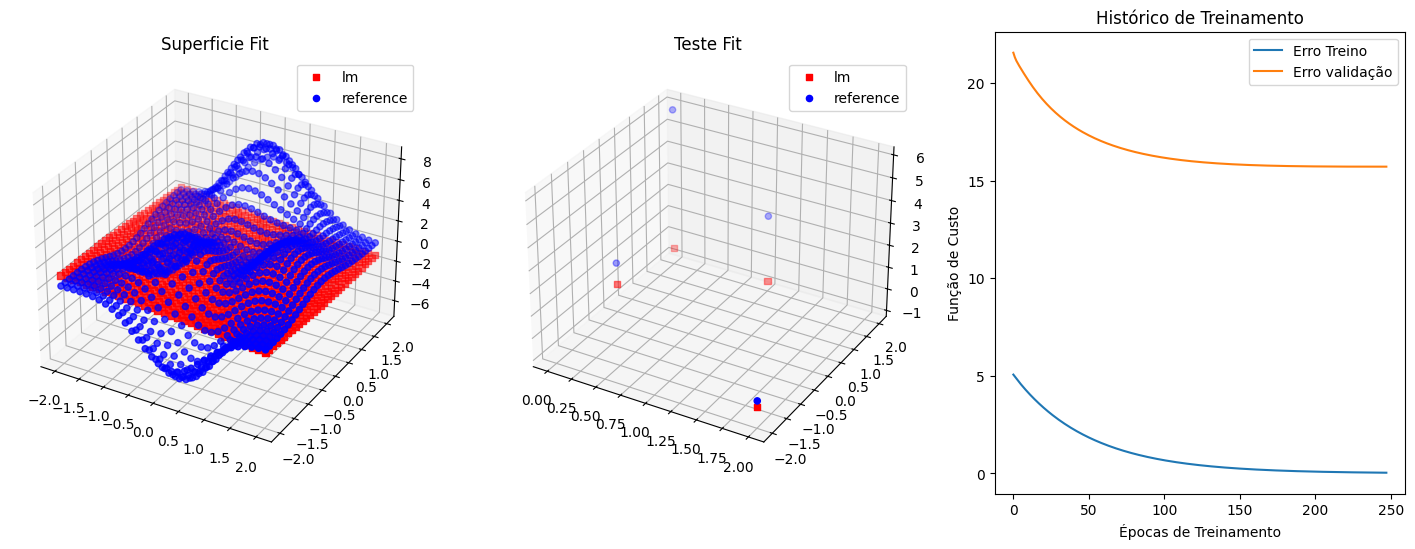

{'r2': 0.8524015905270169, 'r2_sup': 0.6930154483591889, 'r2_test': 0.3109463791857616, 'r2_val': 0.7977431278219125, 'r2_vt': 0.7595262375423896, 'mse': 0.6194389, 'mse_sup': 2.052807, 'mse_test': 0.8874184, 'mse_val': 2.9833856, 'mse_vt': 1.9354019}
1/1 [==============================] - 0s 41ms/step


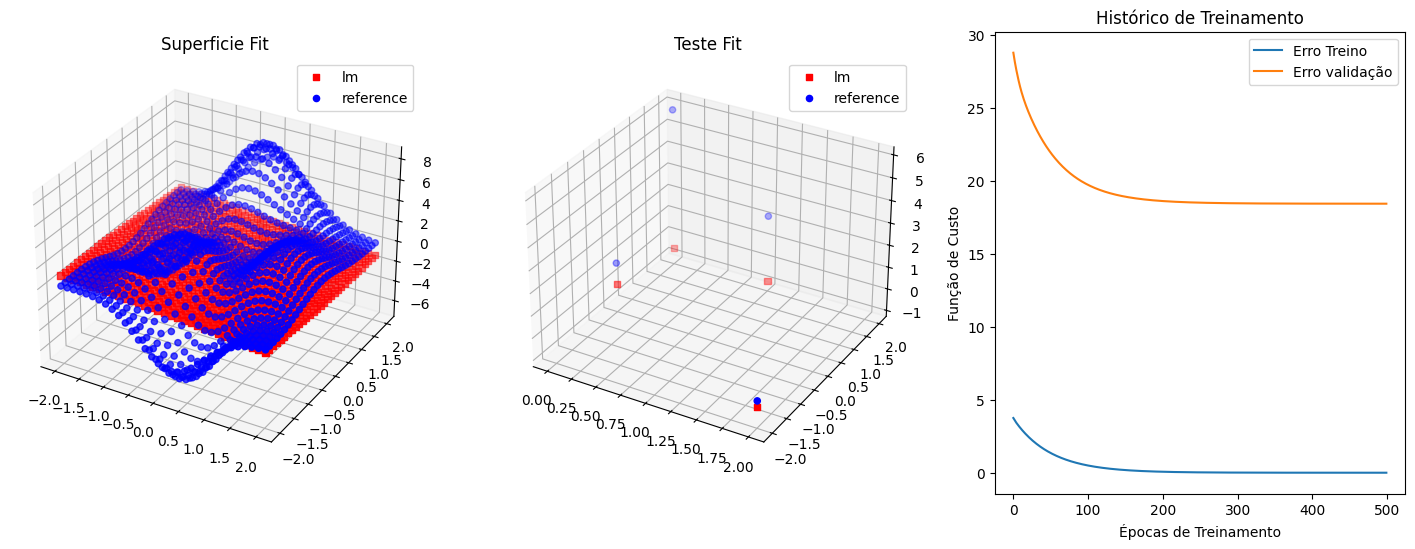

{'r2': 0.8178009584752434, 'r2_sup': 0.653675285310169, 'r2_test': -6.319348048616764, 'r2_val': 0.6380813012845785, 'r2_vt': 0.5874496670846259, 'mse': 0.7646503, 'mse_sup': 2.315875, 'mse_test': 1.0400534, 'mse_val': 3.0109951, 'mse_vt': 2.0255244}
1/1 [==============================] - 0s 39ms/step


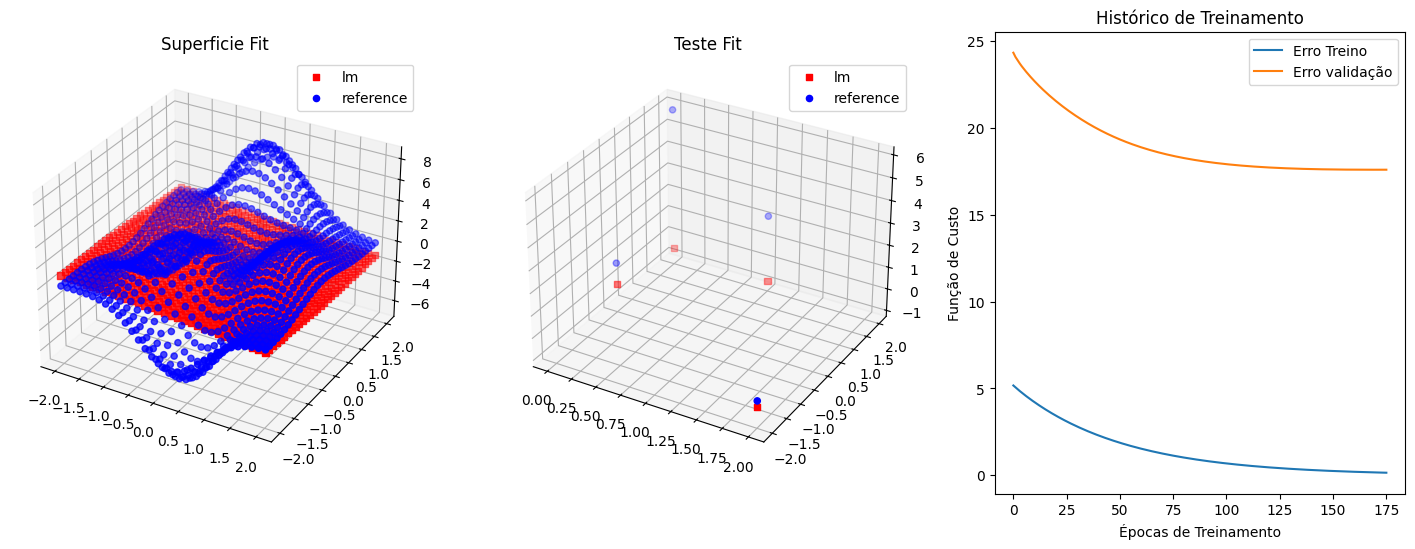

{'r2': 0.8492022573824214, 'r2_sup': 0.6653394168431901, 'r2_test': -0.2630710080544303, 'r2_val': 0.8159681387859832, 'r2_vt': 0.6574035104632872, 'mse': 0.63286585, 'mse_sup': 2.237877, 'mse_test': 2.9678526, 'mse_val': 0.9499347, 'mse_vt': 1.9588938}
1/1 [==============================] - 0s 39ms/step


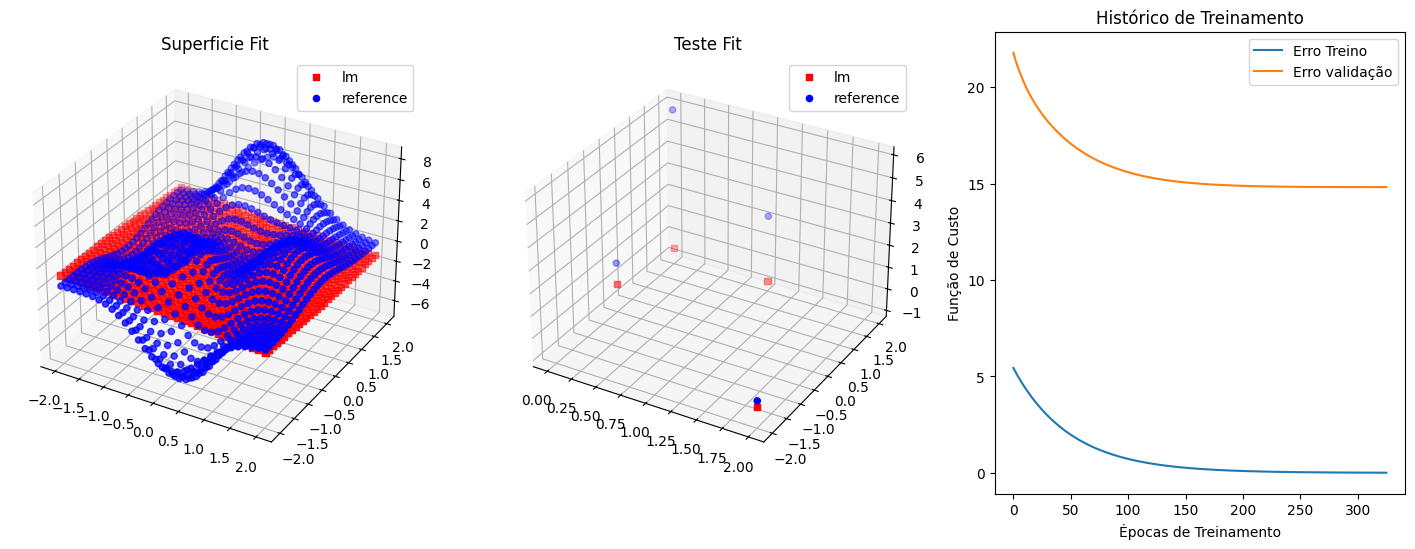

{'r2': 0.8361451757907582, 'r2_sup': 0.6335773616886973, 'r2_test': 0.25753880169839005, 'r2_val': 0.563434783355333, 'r2_vt': 0.6580081429828162, 'mse': 0.68766356, 'mse_sup': 2.45027, 'mse_test': 1.4793042, 'mse_val': 2.1739473, 'mse_vt': 1.8266261}
1/1 [==============================] - 0s 48ms/step


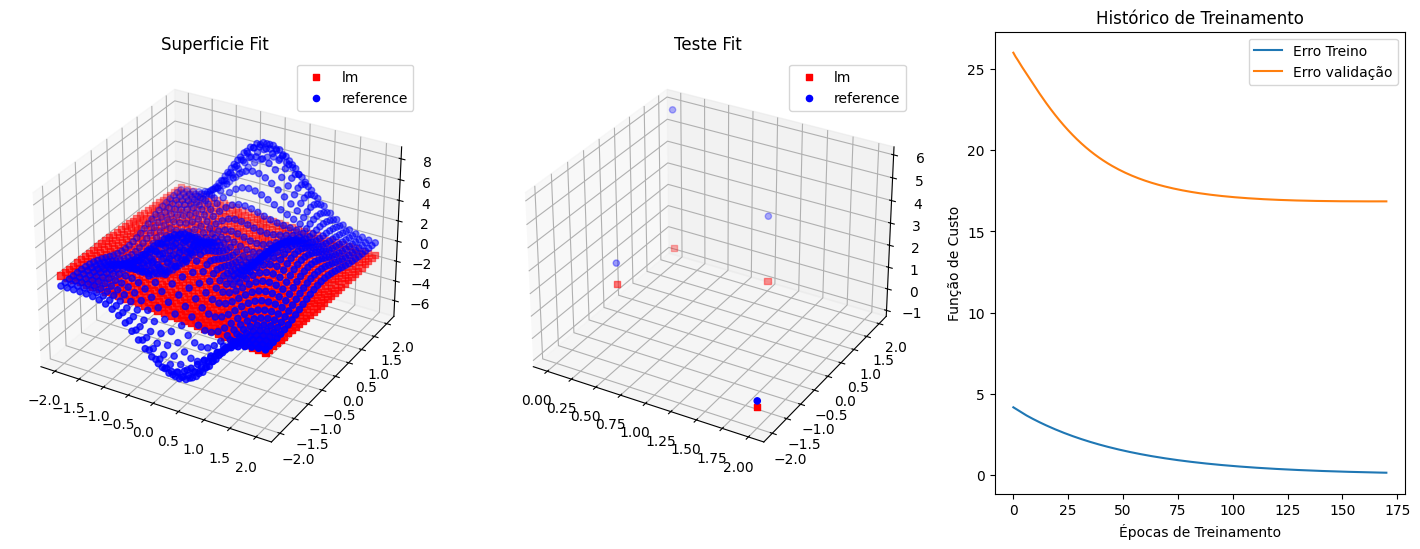

{'r2': 0.888407248756818, 'r2_sup': 0.6385596794800774, 'r2_test': 0.6621499860882345, 'r2_val': 0.7467844905145911, 'r2_vt': 0.7247552439220879, 'mse': 0.46833092, 'mse_sup': 2.416953, 'mse_test': 1.178147, 'mse_val': 1.570828, 'mse_vt': 1.3744876}
1/1 [==============================] - 0s 37ms/step


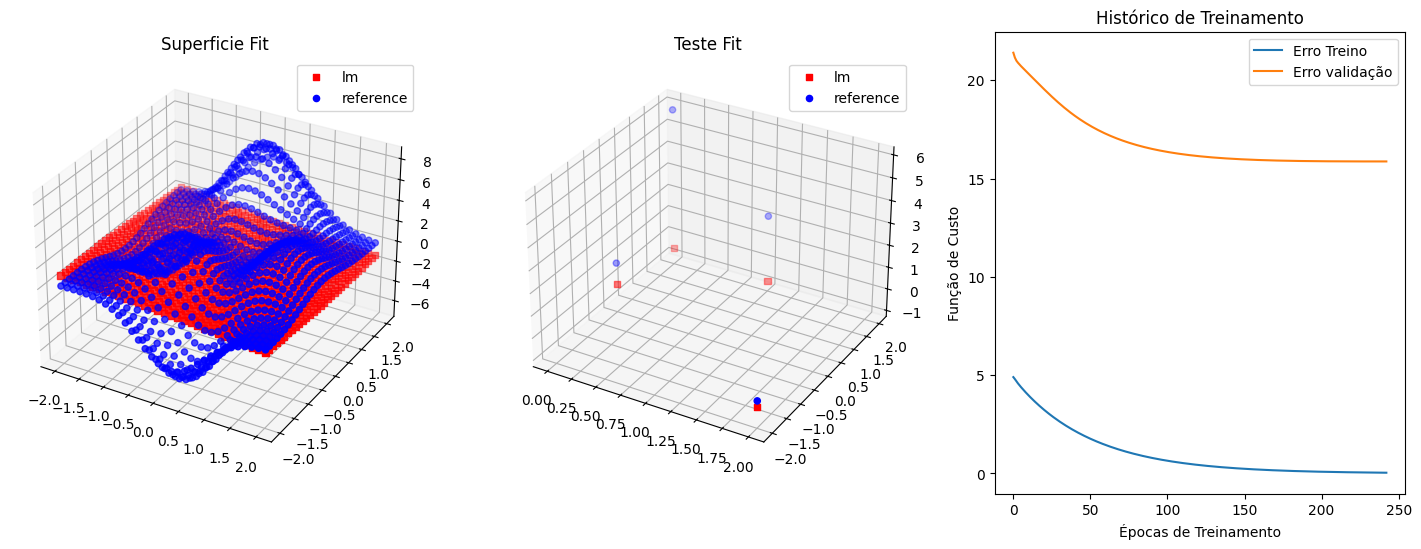

{'r2': 0.8180086800424647, 'r2_sup': 0.6579325655158643, 'r2_test': 0.08728169600910296, 'r2_val': 0.7661985781589109, 'r2_vt': 0.6752892043999079, 'mse': 0.7637786, 'mse_sup': 2.2874064, 'mse_test': 1.5082347, 'mse_val': 2.3685186, 'mse_vt': 1.9383765}
1/1 [==============================] - 0s 36ms/step


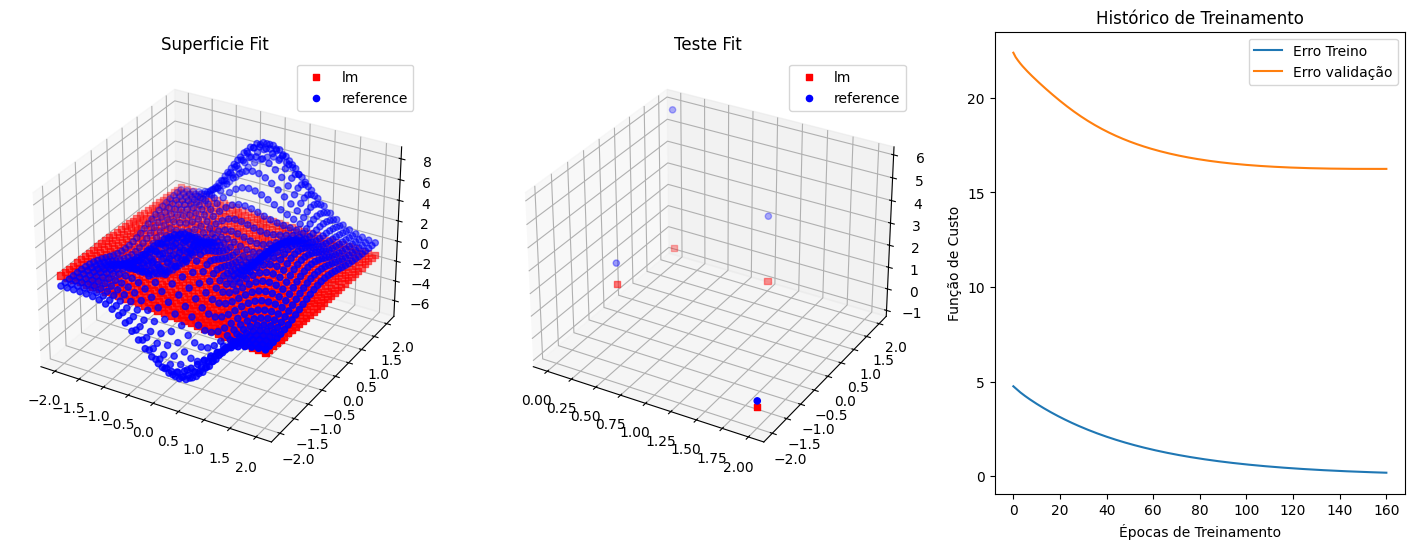

{'r2': 0.847495433493403, 'r2_sup': 0.6411390605281996, 'r2_test': -0.3803245997479485, 'r2_val': 0.8115198088894224, 'r2_vt': 0.6699207422951355, 'mse': 0.640029, 'mse_sup': 2.3997047, 'mse_test': 1.9395502, 'mse_val': 1.8644735, 'mse_vt': 1.9020118}
1/1 [==============================] - 0s 46ms/step


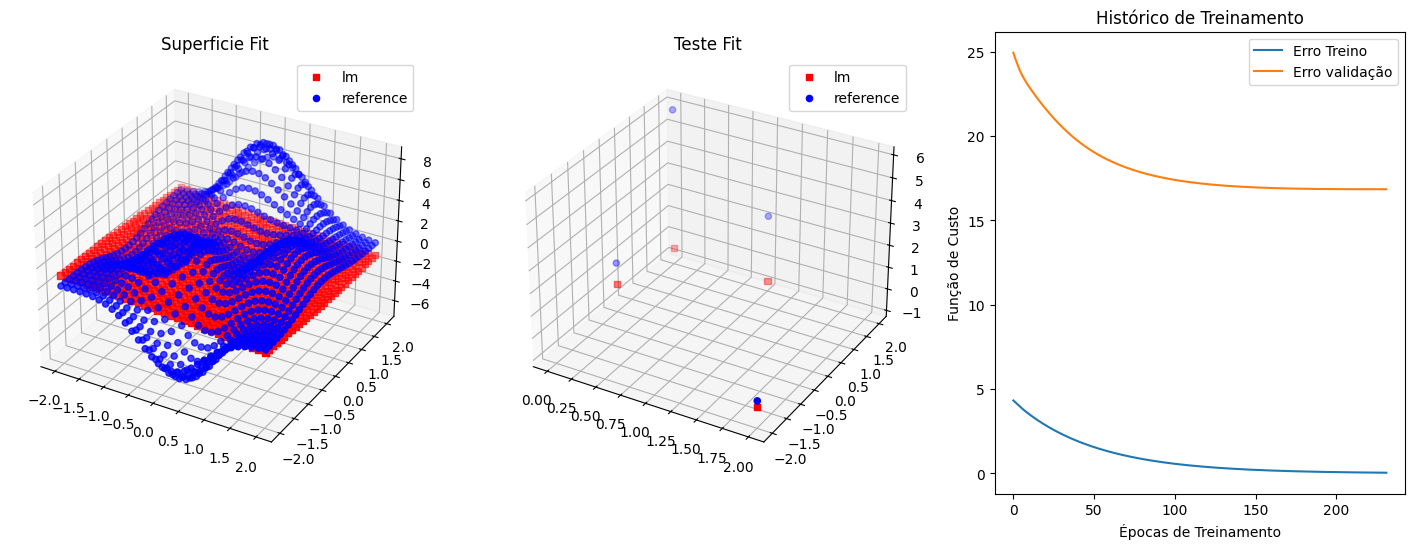

In [28]:
tester.PlotBetterResults()